In [1]:
#importation des données dvf géolocalisées en csv

import os
import s3fs
import pandas as pd
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]

fs = s3fs.S3FileSystem(
    anon=True,
    client_kwargs={"endpoint_url": S3_ENDPOINT_URL}
)

with fs.open("renan/diffusion/dvf.csv", mode="rb") as f:
    df = pd.read_csv(f)

/tmp/ipykernel_2368/352770705.py:14: DtypeWarning: Columns (10,12,14,16,17,18,20,22,24,26,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


In [2]:
# Filtrer pour ne garder que les maisons et appartements
df_filtered = df[df['type_local'].isin(['Maison', 'Appartement'])].copy()

print(f"Nombre de lignes après filtrage : {len(df_filtered)}")
print(f"Réduction : {len(df) - len(df_filtered)} lignes supprimées")

# Vérifier les données de localisation
print(f"\nNombre de communes uniques : {df_filtered['nom_commune'].nunique()}")
print(f"\nValeurs manquantes :")
print(df_filtered[['nom_commune', 'code_commune', 'latitude', 'longitude']].isnull().sum())

Nombre de lignes après filtrage : 6247215
Réduction : 13855524 lignes supprimées

Nombre de communes uniques : 31070

Valeurs manquantes :
nom_commune          0
code_commune         0
latitude        120411
longitude       120411
dtype: int64


In [3]:
# Compter le nombre de ventes par commune
ventes_par_commune = df_filtered.groupby(['nom_commune', 'code_commune']).size().reset_index(name='nb_ventes')

# Trier par nombre de ventes
ventes_par_commune_sorted = ventes_par_commune.sort_values('nb_ventes', ascending=False)

print("Top 20 des communes avec le plus de ventes :")
print(ventes_par_commune_sorted.head(20))
print(f"\nTotal : {len(ventes_par_commune)} communes")

Top 20 des communes avec le plus de ventes :
                    nom_commune code_commune  nb_ventes
30702                  Toulouse        31555      50684
20604                      Nice         6088      46697
20340                    Nantes        44109      30331
3583                   Bordeaux        33063      30077
19542               Montpellier        34172      28927
16456                     Lille        59350      27188
28193             Saint-Étienne        42218      23761
2908                   Besançon        25056      21046
8795                      Dijon        21231      20740
30697                    Toulon        83137      20247
23636                    Rennes        35238      19140
21582  Paris 18e Arrondissement        75118      19136
21579  Paris 15e Arrondissement        75115      18661
23581                     Reims        51454      18288
15332                  Le Havre        76351      17686
11588                  Grenoble        38185      17630
241

In [4]:
# Récupérer les coordonnées moyennes par commune
coords_par_commune = df_filtered.groupby(['nom_commune', 'code_commune']).agg({
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Fusionner avec le nombre de ventes
carte_data = ventes_par_commune.merge(coords_par_commune, on=['nom_commune', 'code_commune'])

# Supprimer les lignes avec des coordonnées manquantes
carte_data = carte_data.dropna(subset=['latitude', 'longitude'])

print(f"Données pour la carte : {len(carte_data)} communes")
print("\nAperçu des données :")
print(carte_data.head(10))

Données pour la carte : 33796 communes

Aperçu des données :
            nom_commune code_commune  nb_ventes   latitude  longitude
0                  Aast        64001         14  43.287360  -0.079459
1            Abainville        55001         34  48.528750   5.494590
2             Abancourt        59001         41  50.232795   3.211181
3             Abancourt        60001         58  49.692235   1.770189
4             Abaucourt        54001         26  48.896953   6.258816
5  Abaucourt-Hautecourt        55002          8  49.194573   5.531167
6        Abbans-Dessous        25001          9  47.133883   5.875038
7         Abbans-Dessus        25002         15  47.117239   5.878950
8              Abbaretz        44001        165  47.554878  -1.515406
9             Abbecourt        60002         74  49.361481   2.158282


In [6]:

import plotly.express as px

# Créer une carte interactive avec plotly
fig = px.scatter_mapbox(
    carte_data,
    lat='latitude',
    lon='longitude',
    size='nb_ventes',
    color='nb_ventes',
    hover_name='nom_commune',
    hover_data={'nb_ventes': True, 'latitude': False, 'longitude': False, 'code_commune': True},
    color_continuous_scale='YlOrRd',
    size_max=30,
    zoom=5,
    title='Densité des ventes de maisons et appartements par commune en France',
    height=800
)

fig.update_layout(
    mapbox_style='open-street-map',
    mapbox_center={'lat': 46.5, 'lon': 2.5}
)

fig.show()

/tmp/ipykernel_2368/3297163345.py:4: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [11]:
import folium
from folium.plugins import HeatMap

# Vérifier si carte_data existe, sinon recréer les données
if 'carte_data' not in locals():
    print("Recréation des données nécessaires...")
    
    # Filtrer pour ne garder que les maisons et appartements
    df_filtered = df[df['type_local'].isin(['Maison', 'Appartement'])].copy()
    
    # Compter le nombre de ventes par commune
    ventes_par_commune = df_filtered.groupby(['nom_commune', 'code_commune']).size().reset_index(name='nb_ventes')
    
    # Récupérer les coordonnées moyennes par commune
    coords_par_commune = df_filtered.groupby(['nom_commune', 'code_commune']).agg({
        'latitude': 'mean',
        'longitude': 'mean'
    }).reset_index()
    
    # Fusionner avec le nombre de ventes
    carte_data = ventes_par_commune.merge(coords_par_commune, on=['nom_commune', 'code_commune'])
    
    # Supprimer les lignes avec des coordonnées manquantes
    carte_data = carte_data.dropna(subset=['latitude', 'longitude'])
    
    print(f"✓ Données créées : {len(carte_data)} communes")

# Préparer les données pour la heatmap (latitude, longitude, intensité)
heat_data = [[row['latitude'], row['longitude'], row['nb_ventes']] 
             for idx, row in carte_data.iterrows()]

# Créer une carte centrée sur la France
m = folium.Map(
    location=[46.5, 2.5],
    zoom_start=6,
    tiles='cartodbpositron'  # Fond clair et épuré
)

# Ajouter la heatmap avec un lissage amélioré
# radius: taille des points (plus grand = plus lisse)
# blur: niveau de flou (plus grand = plus lisse)
HeatMap(
    heat_data,
    min_opacity=0.2,
    max_zoom=13,
    radius=30,       # Augmenté de 15 à 25 pour plus de lissage
    blur=25,         # Augmenté de 20 à 35 pour un effet plus fluide
    gradient={
        0.0: 'blue',
        0.3: 'cyan',
        0.5: 'lime',
        0.7: 'yellow',
        0.9: 'orange',
        1.0: 'red'
    }
).add_to(m)

# Afficher la carte
m

Statistiques des surfaces par type de bien :
                 count        mean        std  min   25%   50%    75%    max
type_local                                                                  
Appartement  2875283.0   56.558654  27.681246  1.0  37.0  54.0   71.0  299.0
Maison       3348431.0  101.454308  42.457127  1.0  74.0  95.0  122.0  299.0


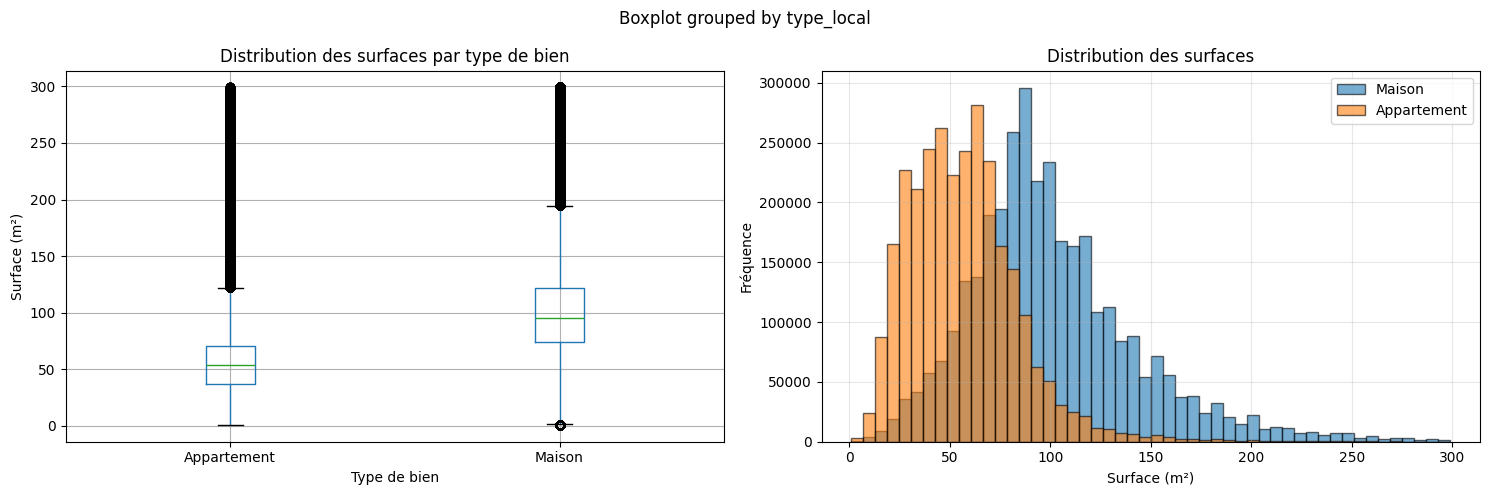

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 4. Analyse des surfaces : impact sur le choix
df_surface = df_filtered[df_filtered['surface_reelle_bati'].notna()].copy()
df_surface = df_surface[df_surface['surface_reelle_bati'] > 0]
df_surface = df_surface[df_surface['surface_reelle_bati'] < 300]  # Enlever les outliers extrêmes

print("Statistiques des surfaces par type de bien :")
print("="*70)
print(df_surface.groupby('type_local')['surface_reelle_bati'].describe())

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Boxplot des surfaces
df_surface.boxplot(column='surface_reelle_bati', by='type_local', ax=axes[0])
axes[0].set_title('Distribution des surfaces par type de bien')
axes[0].set_xlabel('Type de bien')
axes[0].set_ylabel('Surface (m²)')
plt.sca(axes[0])
plt.xticks(rotation=0)

# Histogramme des surfaces
for type_bien in ['Maison', 'Appartement']:
    data = df_surface[df_surface['type_local'] == type_bien]['surface_reelle_bati']
    axes[1].hist(data, bins=50, alpha=0.6, label=type_bien, edgecolor='black')
axes[1].set_title('Distribution des surfaces')
axes[1].set_xlabel('Surface (m²)')
axes[1].set_ylabel('Fréquence')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Statistiques du prix au m² par type de bien :
                 count          mean           std         min          25%  \
type_local                                                                    
Appartement  2758786.0  13521.435234  46181.821382  180.827125  2320.754717   
Maison       3327685.0   3364.452711  11570.221310  180.831826  1408.839779   

                     50%          75%            max  
type_local                                            
Appartement  3750.000000  6677.596552  606884.764706  
Maison       2142.857143  3257.160494  606382.978723  


/tmp/ipykernel_2368/2472439376.py:79: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/python/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



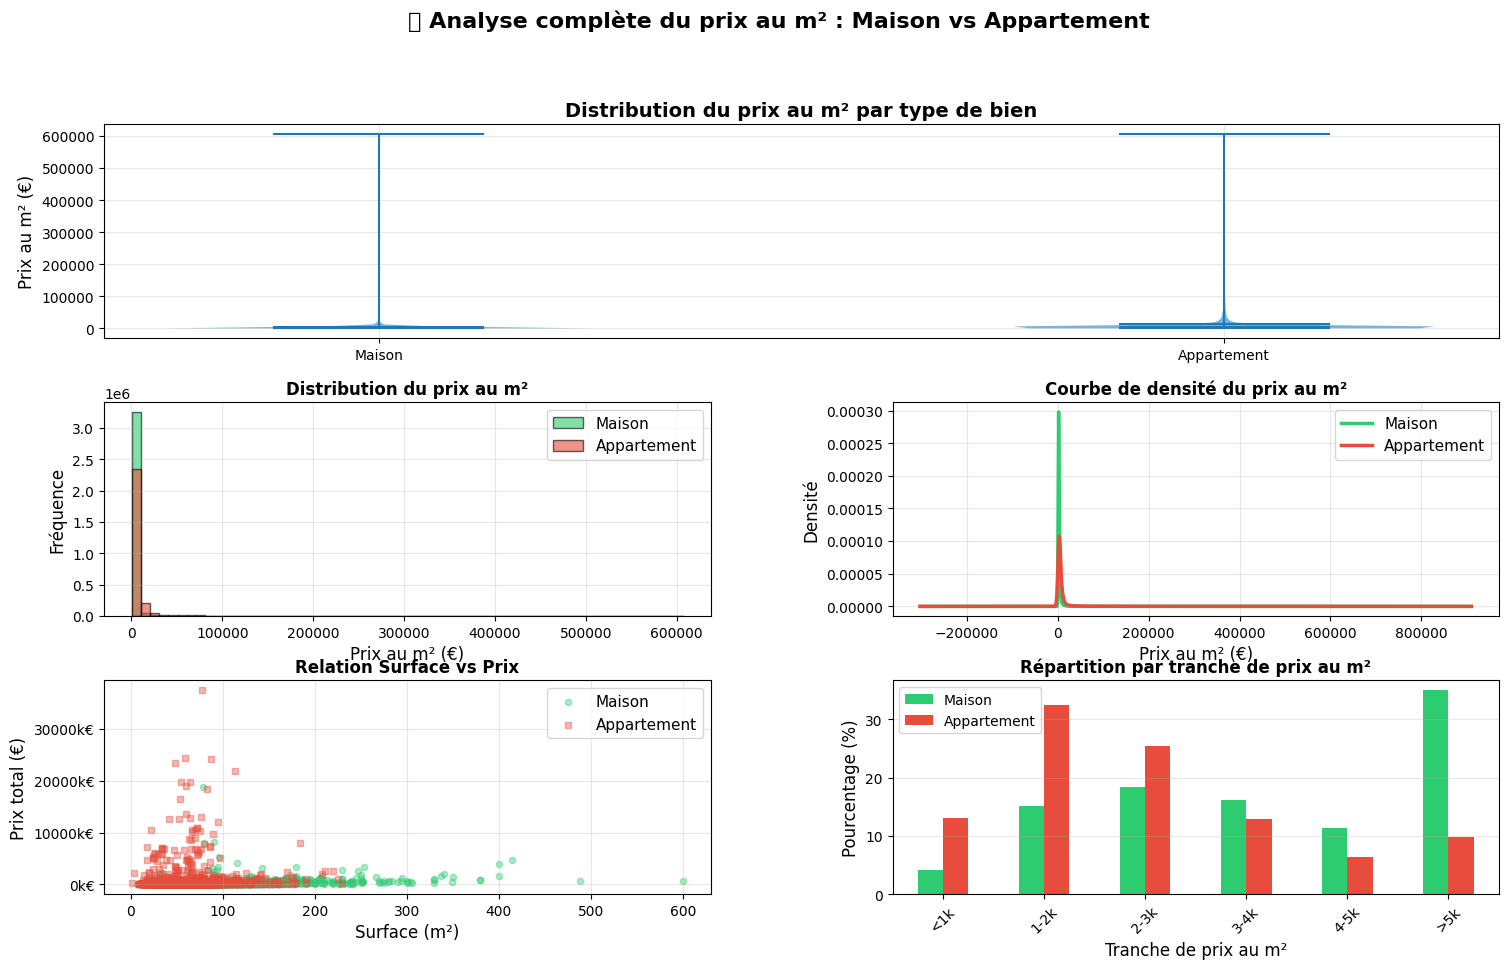


💡 INSIGHTS CLÉS :
   • Prix/m² médian Maison : 2,143€/m²
   • Prix/m² médian Appartement : 3,750€/m²
   • Les appartements sont 75.0% plus chers au m² que les maisons


In [14]:
# 5. Prix au m² : comparaison Maison vs Appartement (VERSION AMÉLIORÉE)
df_prix_m2 = df_filtered[(df_filtered['valeur_fonciere'].notna()) & 
                          (df_filtered['surface_reelle_bati'].notna())].copy()
df_prix_m2 = df_prix_m2[(df_prix_m2['valeur_fonciere'] > 0) & 
                         (df_prix_m2['surface_reelle_bati'] > 0)]

# Calculer le prix au m²
df_prix_m2['prix_m2'] = df_prix_m2['valeur_fonciere'] / df_prix_m2['surface_reelle_bati']

# Enlever les outliers
df_prix_m2 = df_prix_m2[df_prix_m2['prix_m2'] < df_prix_m2['prix_m2'].quantile(0.99)]
df_prix_m2 = df_prix_m2[df_prix_m2['prix_m2'] > df_prix_m2['prix_m2'].quantile(0.01)]

print("Statistiques du prix au m² par type de bien :")
print("="*70)
stats_m2 = df_prix_m2.groupby('type_local')['prix_m2'].describe()
print(stats_m2)

# Visualisation améliorée
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Violin plot pour prix au m²
ax1 = fig.add_subplot(gs[0, :])
parts = ax1.violinplot([df_prix_m2[df_prix_m2['type_local']=='Maison']['prix_m2'],
                         df_prix_m2[df_prix_m2['type_local']=='Appartement']['prix_m2']],
                        positions=[1, 2],
                        showmeans=True,
                        showmedians=True)
for pc in parts['bodies']:
    pc.set_facecolor('#3498db')
    pc.set_alpha(0.7)
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Maison', 'Appartement'])
ax1.set_ylabel('Prix au m² (€)', fontsize=12)
ax1.set_title('Distribution du prix au m² par type de bien', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Histogrammes du prix au m²
ax2 = fig.add_subplot(gs[1, 0])
for type_bien, color in [('Maison', '#2ecc71'), ('Appartement', '#e74c3c')]:
    data = df_prix_m2[df_prix_m2['type_local'] == type_bien]['prix_m2']
    ax2.hist(data, bins=60, alpha=0.6, label=type_bien, color=color, edgecolor='black')
ax2.set_xlabel('Prix au m² (€)', fontsize=12)
ax2.set_ylabel('Fréquence', fontsize=12)
ax2.set_title('Distribution du prix au m²', fontsize=12, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# 3. Courbes de densité
ax3 = fig.add_subplot(gs[1, 1])
for type_bien, color in [('Maison', '#2ecc71'), ('Appartement', '#e74c3c')]:
    data = df_prix_m2[df_prix_m2['type_local'] == type_bien]['prix_m2']
    data.plot.density(ax=ax3, label=type_bien, color=color, linewidth=2.5)
ax3.set_xlabel('Prix au m² (€)', fontsize=12)
ax3.set_ylabel('Densité', fontsize=12)
ax3.set_title('Courbe de densité du prix au m²', fontsize=12, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# 4. Scatter plot : Surface vs Prix total (avec couleur par type)
ax4 = fig.add_subplot(gs[2, 0])
for type_bien, color, marker in [('Maison', '#2ecc71', 'o'), ('Appartement', '#e74c3c', 's')]:
    data = df_prix_m2[df_prix_m2['type_local'] == type_bien].sample(min(2000, len(df_prix_m2[df_prix_m2['type_local'] == type_bien])))
    ax4.scatter(data['surface_reelle_bati'], data['valeur_fonciere'], 
               alpha=0.4, s=20, label=type_bien, color=color, marker=marker)
ax4.set_xlabel('Surface (m²)', fontsize=12)
ax4.set_ylabel('Prix total (€)', fontsize=12)
ax4.set_title('Relation Surface vs Prix', fontsize=12, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}k€'))

# 5. Tranches de prix au m²
ax5 = fig.add_subplot(gs[2, 1])
tranches_m2 = [0, 1000, 2000, 3000, 4000, 5000, float('inf')]
labels_m2 = ['<1k', '1-2k', '2-3k', '3-4k', '4-5k', '>5k']
df_prix_m2['tranche_m2'] = pd.cut(df_prix_m2['prix_m2'], bins=tranches_m2, labels=labels_m2)
tranche_m2_stats = df_prix_m2.groupby(['type_local', 'tranche_m2']).size().unstack(fill_value=0)
tranche_m2_pct = tranche_m2_stats.div(tranche_m2_stats.sum(axis=1), axis=0) * 100
tranche_m2_pct.T.plot(kind='bar', ax=ax5, color=['#2ecc71', '#e74c3c'])
ax5.set_title('Répartition par tranche de prix au m²', fontsize=12, fontweight='bold')
ax5.set_ylabel('Pourcentage (%)', fontsize=12)
ax5.set_xlabel('Tranche de prix au m²', fontsize=12)
ax5.legend(['Maison', 'Appartement'], fontsize=10)
ax5.tick_params(axis='x', rotation=45)
ax5.grid(True, alpha=0.3, axis='y')

plt.suptitle('📊 Analyse complète du prix au m² : Maison vs Appartement', fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Insights détaillés
print("\n" + "="*70)
print("💡 INSIGHTS CLÉS :")
print(f"   • Prix/m² médian Maison : {stats_m2.loc['Maison', '50%']:,.0f}€/m²")
print(f"   • Prix/m² médian Appartement : {stats_m2.loc['Appartement', '50%']:,.0f}€/m²")
diff_pct = ((stats_m2.loc['Appartement', '50%'] - stats_m2.loc['Maison', '50%']) / stats_m2.loc['Maison', '50%']) * 100
print(f"   • Les appartements sont {abs(diff_pct):.1f}% {'plus' if diff_pct > 0 else 'moins'} chers au m² que les maisons")
print("="*70)

In [15]:
# 6. Analyse géographique : quelles régions préfèrent les maisons vs appartements ?
# Extraire le département (2 premiers chiffres du code commune)
df_geo = df_filtered.copy()
df_geo['departement'] = df_geo['code_commune'].astype(str).str[:2]

# Calculer le ratio Maison/Appartement par département
geo_stats = df_geo.groupby(['departement', 'type_local']).size().unstack(fill_value=0)
geo_stats['total'] = geo_stats.sum(axis=1)
geo_stats['pct_maison'] = (geo_stats['Maison'] / geo_stats['total']) * 100
geo_stats['pct_appartement'] = (geo_stats['Appartement'] / geo_stats['total']) * 100

# Trier par préférence pour les maisons
geo_stats_sorted = geo_stats.sort_values('pct_maison', ascending=False)

print("Top 15 départements avec le plus de ventes de MAISONS :")
print("="*70)
print(geo_stats_sorted[['Maison', 'Appartement', 'pct_maison']].head(15))

print("\n\nTop 15 départements avec le plus de ventes d'APPARTEMENTS :")
print("="*70)
print(geo_stats_sorted[['Maison', 'Appartement', 'pct_appartement']].tail(15).sort_values('pct_appartement', ascending=False))

Top 15 départements avec le plus de ventes de MAISONS :
type_local   Maison  Appartement  pct_maison
departement                                 
20             3854          211   94.809348
79            35711         5549   86.551139
16            34406         5542   86.126965
36            20354         3408   85.657773
23            18860         3368   84.847940
27            59761        11381   84.002418
32            23224         4809   82.845218
85            66741        14490   82.161982
53            26379         5850   81.848646
46            17899         3988   81.779138
52            12332         2935   80.775529
41            34982         8858   79.794708
72            51689        13202   79.655114
47            32960         8535   79.431257
28            34957         9256   79.064981


Top 15 départements avec le plus de ventes d'APPARTEMENTS :
type_local   Maison  Appartement  pct_appartement
departement                                      
75              9

In [16]:
# 6a. Récupération des données de densité de population par département
print("Récupération des données de population et densité par département...")

# Données de population et superficie par département (France métropolitaine)
# Source : INSEE 2023 (données approximatives)
dept_data = {
    '01': {'nom': 'Ain', 'population': 652000, 'superficie': 5762},
    '02': {'nom': 'Aisne', 'population': 531000, 'superficie': 7369},
    '03': {'nom': 'Allier', 'population': 335000, 'superficie': 7340},
    '04': {'nom': 'Alpes-de-Haute-Provence', 'population': 164000, 'superficie': 6925},
    '05': {'nom': 'Hautes-Alpes', 'population': 141000, 'superficie': 5549},
    '06': {'nom': 'Alpes-Maritimes', 'population': 1083000, 'superficie': 4299},
    '07': {'nom': 'Ardèche', 'population': 328000, 'superficie': 5529},
    '08': {'nom': 'Ardennes', 'population': 270000, 'superficie': 5229},
    '09': {'nom': 'Ariège', 'population': 153000, 'superficie': 4890},
    '10': {'nom': 'Aube', 'population': 310000, 'superficie': 6004},
    '11': {'nom': 'Aude', 'population': 374000, 'superficie': 6139},
    '12': {'nom': 'Aveyron', 'population': 279000, 'superficie': 8735},
    '13': {'nom': 'Bouches-du-Rhône', 'population': 2043000, 'superficie': 5087},
    '14': {'nom': 'Calvados', 'population': 694000, 'superficie': 5548},
    '15': {'nom': 'Cantal', 'population': 144000, 'superficie': 5726},
    '16': {'nom': 'Charente', 'population': 352000, 'superficie': 5956},
    '17': {'nom': 'Charente-Maritime', 'population': 651000, 'superficie': 6864},
    '18': {'nom': 'Cher', 'population': 302000, 'superficie': 7235},
    '19': {'nom': 'Corrèze', 'population': 240000, 'superficie': 5857},
    '21': {'nom': "Côte-d'Or", 'population': 534000, 'superficie': 8763},
    '22': {'nom': "Côtes-d'Armor", 'population': 600000, 'superficie': 6878},
    '23': {'nom': 'Creuse', 'population': 116000, 'superficie': 5565},
    '24': {'nom': 'Dordogne', 'population': 413000, 'superficie': 9060},
    '25': {'nom': 'Doubs', 'population': 543000, 'superficie': 5234},
    '26': {'nom': 'Drôme', 'population': 516000, 'superficie': 6530},
    '27': {'nom': 'Eure', 'population': 599000, 'superficie': 6040},
    '28': {'nom': 'Eure-et-Loir', 'population': 431000, 'superficie': 5880},
    '29': {'nom': 'Finistère', 'population': 915000, 'superficie': 6733},
    '30': {'nom': 'Gard', 'population': 748000, 'superficie': 5853},
    '31': {'nom': 'Haute-Garonne', 'population': 1415000, 'superficie': 6309},
    '32': {'nom': 'Gers', 'population': 191000, 'superficie': 6257},
    '33': {'nom': 'Gironde', 'population': 1623000, 'superficie': 9976},
    '34': {'nom': 'Hérault', 'population': 1175000, 'superficie': 6101},
    '35': {'nom': 'Ille-et-Vilaine', 'population': 1079000, 'superficie': 6775},
    '36': {'nom': 'Indre', 'population': 219000, 'superficie': 6791},
    '37': {'nom': 'Indre-et-Loire', 'population': 610000, 'superficie': 6127},
    '38': {'nom': 'Isère', 'population': 1271000, 'superficie': 7431},
    '39': {'nom': 'Jura', 'population': 259000, 'superficie': 4999},
    '40': {'nom': 'Landes', 'population': 413000, 'superficie': 9243},
    '41': {'nom': 'Loir-et-Cher', 'population': 329000, 'superficie': 6343},
    '42': {'nom': 'Loire', 'population': 765000, 'superficie': 4781},
    '43': {'nom': 'Haute-Loire', 'population': 227000, 'superficie': 4977},
    '44': {'nom': 'Loire-Atlantique', 'population': 1429000, 'superficie': 6815},
    '45': {'nom': 'Loiret', 'population': 680000, 'superficie': 6775},
    '46': {'nom': 'Lot', 'population': 174000, 'superficie': 5217},
    '47': {'nom': 'Lot-et-Garonne', 'population': 333000, 'superficie': 5361},
    '48': {'nom': 'Lozère', 'population': 76000, 'superficie': 5167},
    '49': {'nom': 'Maine-et-Loire', 'population': 818000, 'superficie': 7166},
    '50': {'nom': 'Manche', 'population': 496000, 'superficie': 5938},
    '51': {'nom': 'Marne', 'population': 566000, 'superficie': 8162},
    '52': {'nom': 'Haute-Marne', 'population': 172000, 'superficie': 6211},
    '53': {'nom': 'Mayenne', 'population': 307000, 'superficie': 5175},
    '54': {'nom': 'Meurthe-et-Moselle', 'population': 733000, 'superficie': 5246},
    '55': {'nom': 'Meuse', 'population': 184000, 'superficie': 6211},
    '56': {'nom': 'Morbihan', 'population': 750000, 'superficie': 6823},
    '57': {'nom': 'Moselle', 'population': 1043000, 'superficie': 6216},
    '58': {'nom': 'Nièvre', 'population': 204000, 'superficie': 6817},
    '59': {'nom': 'Nord', 'population': 2604000, 'superficie': 5743},
    '60': {'nom': 'Oise', 'population': 829000, 'superficie': 5860},
    '61': {'nom': 'Orne', 'population': 279000, 'superficie': 6103},
    '62': {'nom': 'Pas-de-Calais', 'population': 1465000, 'superficie': 6671},
    '63': {'nom': 'Puy-de-Dôme', 'population': 662000, 'superficie': 7970},
    '64': {'nom': 'Pyrénées-Atlantiques', 'population': 682000, 'superficie': 7645},
    '65': {'nom': 'Hautes-Pyrénées', 'population': 229000, 'superficie': 4464},
    '66': {'nom': 'Pyrénées-Orientales', 'population': 479000, 'superficie': 4116},
    '67': {'nom': 'Bas-Rhin', 'population': 1140000, 'superficie': 4755},
    '68': {'nom': 'Haut-Rhin', 'population': 767000, 'superficie': 3525},
    '69': {'nom': 'Rhône', 'population': 1873000, 'superficie': 3249},
    '70': {'nom': 'Haute-Saône', 'population': 235000, 'superficie': 5360},
    '71': {'nom': 'Saône-et-Loire', 'population': 551000, 'superficie': 8575},
    '72': {'nom': 'Sarthe', 'population': 566000, 'superficie': 6206},
    '73': {'nom': 'Savoie', 'population': 436000, 'superficie': 6028},
    '74': {'nom': 'Haute-Savoie', 'population': 825000, 'superficie': 4388},
    '75': {'nom': 'Paris', 'population': 2161000, 'superficie': 105},
    '76': {'nom': 'Seine-Maritime', 'population': 1255000, 'superficie': 6278},
    '77': {'nom': 'Seine-et-Marne', 'population': 1421000, 'superficie': 5915},
    '78': {'nom': 'Yvelines', 'population': 1431000, 'superficie': 2284},
    '79': {'nom': 'Deux-Sèvres', 'population': 374000, 'superficie': 5999},
    '80': {'nom': 'Somme', 'population': 570000, 'superficie': 6170},
    '81': {'nom': 'Tarn', 'population': 387000, 'superficie': 5758},
    '82': {'nom': 'Tarn-et-Garonne', 'population': 260000, 'superficie': 3718},
    '83': {'nom': 'Var', 'population': 1076000, 'superficie': 5973},
    '84': {'nom': 'Vaucluse', 'population': 559000, 'superficie': 3567},
    '85': {'nom': 'Vendée', 'population': 685000, 'superficie': 6720},
    '86': {'nom': 'Vienne', 'population': 438000, 'superficie': 6990},
    '87': {'nom': 'Haute-Vienne', 'population': 374000, 'superficie': 5520},
    '88': {'nom': 'Vosges', 'population': 364000, 'superficie': 5874},
    '89': {'nom': 'Yonne', 'population': 338000, 'superficie': 7427},
    '90': {'nom': 'Territoire de Belfort', 'population': 141000, 'superficie': 609},
    '91': {'nom': 'Essonne', 'population': 1301000, 'superficie': 1804},
    '92': {'nom': 'Hauts-de-Seine', 'population': 1609000, 'superficie': 176},
    '93': {'nom': 'Seine-Saint-Denis', 'population': 1632000, 'superficie': 236},
    '94': {'nom': "Val-de-Marne", 'population': 1398000, 'superficie': 245},
    '95': {'nom': "Val-d'Oise", 'population': 1249000, 'superficie': 1246},
}

# Créer un DataFrame avec ces données
df_dept_info = pd.DataFrame.from_dict(dept_data, orient='index')
df_dept_info.index.name = 'departement'
df_dept_info.reset_index(inplace=True)

# Calculer la densité (habitants/km²)
df_dept_info['densite'] = df_dept_info['population'] / df_dept_info['superficie']

print(f"✓ Données chargées pour {len(df_dept_info)} départements")
print("\nAperçu des données :")
print(df_dept_info.head(10))
print("\n5 départements les plus denses :")
print(df_dept_info.nlargest(5, 'densite')[['departement', 'nom', 'densite']])

Récupération des données de population et densité par département...
✓ Données chargées pour 94 départements

Aperçu des données :
  departement                      nom  population  superficie     densite
0          01                      Ain      652000        5762  113.155154
1          02                    Aisne      531000        7369   72.058624
2          03                   Allier      335000        7340   45.640327
3          04  Alpes-de-Haute-Provence      164000        6925   23.682310
4          05             Hautes-Alpes      141000        5549   25.409984
5          06          Alpes-Maritimes     1083000        4299  251.919051
6          07                  Ardèche      328000        5529   59.323567
7          08                 Ardennes      270000        5229   51.635112
8          09                   Ariège      153000        4890   31.288344
9          10                     Aube      310000        6004   51.632245

5 départements les plus denses :
   departe

/tmp/ipykernel_2368/3179703085.py:104: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2368/3179703085.py:115: UserWarning:

Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.

/opt/python/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.



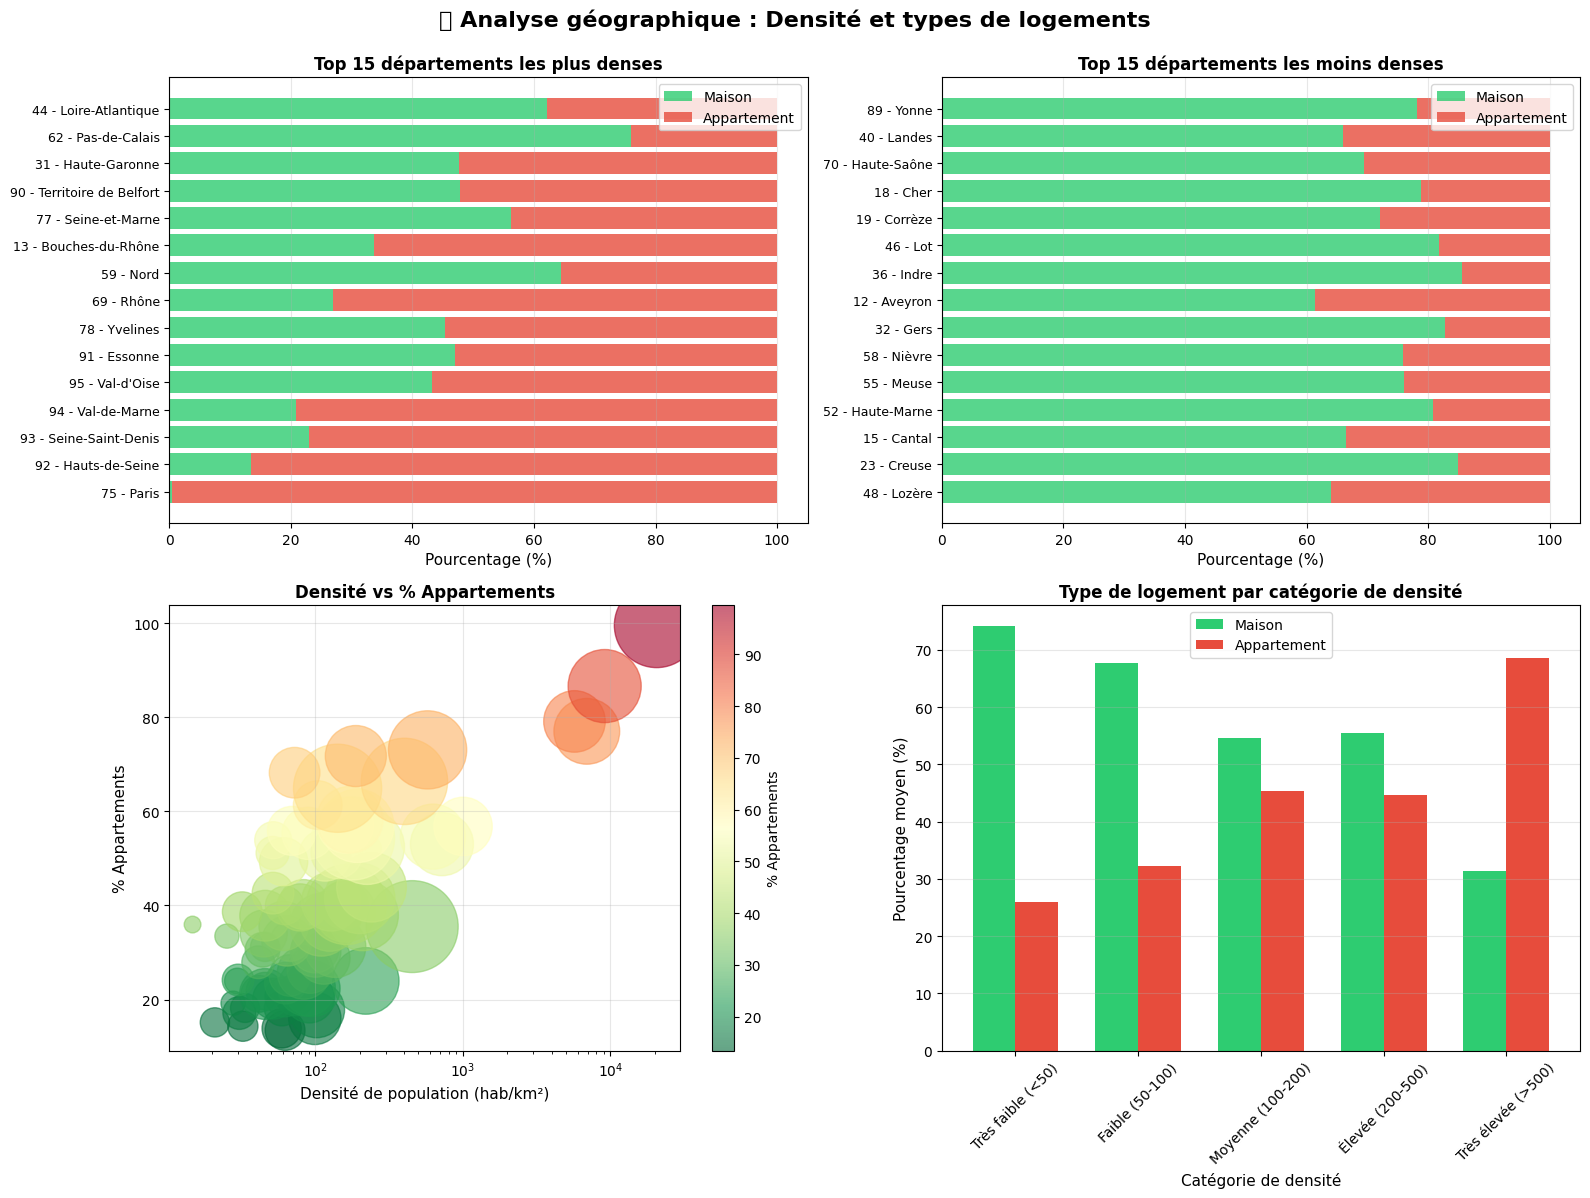


💡 INSIGHTS GÉOGRAPHIQUES :
   • Départements très denses (>500 hab/km²) : 8
     → % moyen d'appartements : 72.5%
   • Départements peu denses (<50 hab/km²) : 18
     → % moyen d'appartements : 25.9%

   • Corrélation densité/appartements : 0.565


In [17]:
# 7. Carte : Préférence Maison vs Appartement par département (VERSION AMÉLIORÉE)

# Fusionner avec les données de densité
geo_stats_with_info = geo_stats_sorted.reset_index().merge(df_dept_info, on='departement', how='left')

# Créer une colonne pour l'affichage avec nom du département
geo_stats_with_info['dept_nom'] = geo_stats_with_info['departement'] + ' - ' + geo_stats_with_info['nom'].fillna('Inconnu')

# Visualisation 1 : Graphique en barres empilées avec noms
fig1 = px.bar(geo_stats_with_info.head(30), 
             x='dept_nom', 
             y=['pct_maison', 'pct_appartement'],
             title='Répartition Maison vs Appartement par département (Top 30)',
             labels={'value': 'Pourcentage (%)', 'dept_nom': 'Département'},
             barmode='stack',
             height=600,
             color_discrete_map={'pct_maison': '#2ecc71', 'pct_appartement': '#e74c3c'},
             hover_data={'densite': ':.0f'})

fig1.update_layout(
    xaxis_title='Département',
    yaxis_title='Pourcentage (%)',
    legend_title='Type de bien',
    hovermode='x unified',
    xaxis_tickangle=-45
)

fig1.show()

# Visualisation 2 : Relation entre densité et type de logement
fig2 = px.scatter(geo_stats_with_info.dropna(subset=['densite']), 
                 x='densite', 
                 y='pct_appartement',
                 size='total',
                 color='pct_appartement',
                 hover_name='dept_nom',
                 hover_data={'Maison': True, 'Appartement': True, 'densite': ':.0f'},
                 title='Corrélation : Densité de population vs % Appartements',
                 labels={'densite': 'Densité (hab/km²)', 'pct_appartement': '% Appartements'},
                 color_continuous_scale='Reds',
                 height=600)

fig2.update_layout(
    xaxis_title='Densité de population (habitants/km²)',
    yaxis_title='Pourcentage d\'Appartements (%)',
    xaxis_type='log'  # Échelle logarithmique pour mieux voir la distribution
)

fig2.show()

# Visualisation 3 : Classification des départements
fig3, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sous-graphique 1 : Top 15 plus denses
ax1 = axes[0, 0]
top_dense = geo_stats_with_info.nlargest(15, 'densite')
x_pos = range(len(top_dense))
ax1.barh(x_pos, top_dense['pct_maison'], label='Maison', color='#2ecc71', alpha=0.8)
ax1.barh(x_pos, top_dense['pct_appartement'], left=top_dense['pct_maison'], 
         label='Appartement', color='#e74c3c', alpha=0.8)
ax1.set_yticks(x_pos)
ax1.set_yticklabels(top_dense['dept_nom'], fontsize=9)
ax1.set_xlabel('Pourcentage (%)', fontsize=11)
ax1.set_title('Top 15 départements les plus denses', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Sous-graphique 2 : Top 15 moins denses
ax2 = axes[0, 1]
bottom_dense = geo_stats_with_info.nsmallest(15, 'densite')
x_pos = range(len(bottom_dense))
ax2.barh(x_pos, bottom_dense['pct_maison'], label='Maison', color='#2ecc71', alpha=0.8)
ax2.barh(x_pos, bottom_dense['pct_appartement'], left=bottom_dense['pct_maison'], 
         label='Appartement', color='#e74c3c', alpha=0.8)
ax2.set_yticks(x_pos)
ax2.set_yticklabels(bottom_dense['dept_nom'], fontsize=9)
ax2.set_xlabel('Pourcentage (%)', fontsize=11)
ax2.set_title('Top 15 départements les moins denses', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')

# Sous-graphique 3 : Scatter densité vs % appartements
ax3 = axes[1, 0]
scatter = ax3.scatter(geo_stats_with_info['densite'], 
                     geo_stats_with_info['pct_appartement'],
                     s=geo_stats_with_info['total']/50,
                     alpha=0.6,
                     c=geo_stats_with_info['pct_appartement'],
                     cmap='RdYlGn_r')
ax3.set_xlabel('Densité de population (hab/km²)', fontsize=11)
ax3.set_ylabel('% Appartements', fontsize=11)
ax3.set_title('Densité vs % Appartements', fontsize=12, fontweight='bold')
ax3.set_xscale('log')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='% Appartements')

# Sous-graphique 4 : Catégories de densité
ax4 = axes[1, 1]
geo_stats_with_info['categorie_densite'] = pd.cut(geo_stats_with_info['densite'], 
                                                   bins=[0, 50, 100, 200, 500, 10000],
                                                   labels=['Très faible (<50)', 'Faible (50-100)', 
                                                          'Moyenne (100-200)', 'Élevée (200-500)', 
                                                          'Très élevée (>500)'])
cat_stats = geo_stats_with_info.groupby('categorie_densite')[['pct_maison', 'pct_appartement']].mean()
cat_stats.plot(kind='bar', ax=ax4, color=['#2ecc71', '#e74c3c'], width=0.7)
ax4.set_xlabel('Catégorie de densité', fontsize=11)
ax4.set_ylabel('Pourcentage moyen (%)', fontsize=11)
ax4.set_title('Type de logement par catégorie de densité', fontsize=12, fontweight='bold')
ax4.legend(['Maison', 'Appartement'])
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('🗺️ Analyse géographique : Densité et types de logements', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Statistiques détaillées
print("\n" + "="*70)
print("💡 INSIGHTS GÉOGRAPHIQUES :")
print("="*70)
tres_dense = geo_stats_with_info[geo_stats_with_info['densite'] > 500]
peu_dense = geo_stats_with_info[geo_stats_with_info['densite'] < 50]
print(f"   • Départements très denses (>500 hab/km²) : {len(tres_dense)}")
print(f"     → % moyen d'appartements : {tres_dense['pct_appartement'].mean():.1f}%")
print(f"   • Départements peu denses (<50 hab/km²) : {len(peu_dense)}")
print(f"     → % moyen d'appartements : {peu_dense['pct_appartement'].mean():.1f}%")
print(f"\n   • Corrélation densité/appartements : {geo_stats_with_info[['densite', 'pct_appartement']].corr().iloc[0,1]:.3f}")
print("="*70)